# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy
import pickle
from sklearn.model_selection import train_test_split
import random
from matplotlib import pyplot
%matplotlib inline
import math

## Load *Dataset*
Load data from the given pickle file

In [2]:
# mount Google Drive to access the dataset
data_file="train_data.pkl"

# load the data set
with open(data_file,'rb') as infile:
    train_dataset = pickle.load(infile)
    
image_data = train_dataset['X'] # X is a 60,000 x 784 matrix representing 60,000 images with 784 pixel values each
labels = train_dataset['y'] # y is a 60,000 x 1 matrix which contains corresponding labels

# normalize
# mean_image_data = numpy.zeros([1,image_data.shape[1]], dtype='float64')
# for i in range(0,60000):
#     mean_image_data += image_data[i:i+1,:]
# mean_image_data/=60000
# normalized_image_data = image_data - mean_image_data
normalized_image_data = numpy.zeros(image_data.shape)
normalized_image_data += image_data - numpy.min(image_data,axis=0,keepdims=True)
max_image_data = numpy.max(normalized_image_data,axis=0,keepdims=True)
for i in range(image_data.shape[1]):
    if(max_image_data[0][i]==0):
        max_image_data[0][i] = 1
normalized_image_data /= max_image_data

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
train_images,test_images,train_labels,test_labels = train_test_split(image_data,labels,stratify=labels,test_size=0.2)

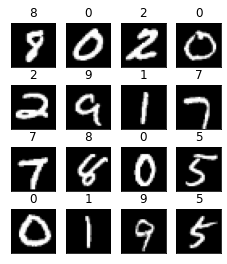

In [3]:
# display a 4x4 grid,
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1,17):
    pyplot.subplot(4,4,i)
    idx=random.randrange(0,60000,1)
    image_pixels=numpy.array(image_data[idx]).reshape(28,28)
    curr_image=pyplot.imshow(image_pixels,cmap='gray')
    curr_image.axes.get_xaxis().set_visible(False)
    curr_image.axes.get_yaxis().set_visible(False)
    pyplot.title((labels[idx][0]))
pyplot.subplots_adjust(left=0.0, bottom=0.1, right=0.5, top=0.9, wspace=0.1, hspace=0.4)
pyplot.show()

## Building up parts of our classifier

**Activation functions**

In [4]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return numpy.maximum(z,numpy.zeros(z.shape))

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    z_small = z - numpy.max(z,axis=1,keepdims=True)
    exp_z = numpy.exp(z_small)
    denom = numpy.sum(exp_z,axis = 1,keepdims=True)
    return exp_z/denom

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [5]:
def init_params(total_images,input_dim,hidden_dim,output_dim):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    W0 = 0.01 * numpy.random.randn(input_dim,hidden_dim) / math.sqrt(input_dim / 2)
    b0 = numpy.zeros((hidden_dim,1))
    b1 = numpy.zeros((output_dim,1))
    W1 = 0.01 * numpy.random.randn(hidden_dim,output_dim) / math.sqrt(hidden_dim / 2)
    return (W0,b0,W1,b1)

**Forward Propagation**

In [6]:
def forward_propg(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    weights=(W0,b0,W1,b1)
    using ReLu non-Linearity
    """
    W0,b0,W1,b1 = weights
    hidden_layer = relu(X.dot(W0)+b0.T)
    output_layer = (hidden_layer.dot(W1)+b1.T)
    return (hidden_layer,output_layer)

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [7]:
def backward_propg(weights, X, y, layers, learning_rate):
    """
    should update the weights and return updated weights
    """
    W0,b0,W1,b1 = weights
    hidden_layer,output_layer = layers
    loss=0
    prob_matrix = softmax(output_layer)
    grad = prob_matrix
    x=numpy.arange(output_layer.shape[0])
    grad[x,y.T] -= 1
    # for x in range(output_layer.shape[0]):
    #     grad[x][y[x][0]] -= 1 
    grad /= output_layer.shape[0]
    # now grad has gradient of loss w.r.t. output_layer
    # grad = grad * (output_layer > 0)
    grad_b1 = numpy.sum(grad,axis=0,keepdims=True).T
    grad_W1 = numpy.dot(hidden_layer.T , grad)
    grad = numpy.dot(grad, W1.T) 
    # now grad has grad w.r.t hidden layer
    grad = grad * (hidden_layer > 0)
    grad_b0 = numpy.sum(grad,axis=0,keepdims=True).T
    grad_W0 = numpy.dot(X.T , grad)
    # value updation(normal linear update)
    W1 -= grad_W1 * learning_rate
    W0 -= grad_W0 * learning_rate
    b0 -= grad_b0 * learning_rate
    b1 -= grad_b1 * learning_rate
    return (W0,b0,W1,b1) # or return (W0,W1,b0,b1,loss)

In [8]:
def cost_func(y,output_layer):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    loss=0
    prob = softmax(output_layer)
    prob = -1* numpy.log(prob)
#     return numpy.sum(numpy.diagonal(output_layer.T[y]))/output_layer.shape[0]
    loss = prob[numpy.arange(output_layer.shape[0]),y.T].sum()
    # for x in range(output_layer.shape[0]):
    #     loss += prob[x][y[x][0]]
    loss/=output_layer.shape[0]
    return loss


## Integrate everything

In [9]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    weights = init_params(X.shape[0],X.shape[1],hidden_nodes,10)
    for i in range(epochs):
        bigX,smallX,bigy,smally = train_test_split(X,y,stratify=y,test_size=256/48000)
        # smallX=X
        # smally=y
        # forward propagation
        layers = forward_propg(smallX, weights)
        # print cost at every 100 or so iterations
        loss = cost_func(smally,layers[1])
        if (i%100)==0:
            print(i,'th iteration:\nLoss:',loss,'\t lr:',lr)
        # backward propagation
        weights = backward_propg(weights, smallX, smally, layers, lr)
    return weights

In [10]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    W0,b0,W1,b1 = updated_weights
    hidden_dim = relu(X.dot(W0)+b0.T)
    scores = (hidden_dim.dot(W1)+b1.T)
    predictions = numpy.argmax(scores,axis=1,keepdims=True)
    return predictions
    ans = numpy.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        for j in range(0,10):
            if predictions[i][j]:
                ans[i][0] = j
                break
    return ans

In [11]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    total=predictions.shape[0]
    correct=(predictions==y)
    count=correct.sum()
    print('Accuracy=',count*100/total)
    return
    for i in range(0,total):
        if(correct[i]):
            count+=1
    print('Accuracy=',count*100/total)

In [12]:
weights = train(train_images,train_labels,256,lr = 1e-3)
ans = predict(test_images, weights)
accuracy(ans,test_labels)

0 th iteration:
Loss: 2.302928390075917 	 lr: 0.001
100 th iteration:
Loss: 0.49789760225743873 	 lr: 0.001
200 th iteration:
Loss: 0.2938763791239336 	 lr: 0.001
300 th iteration:
Loss: 0.2768128279501788 	 lr: 0.001
400 th iteration:
Loss: 0.2797758323987911 	 lr: 0.001
500 th iteration:
Loss: 0.19697690354826541 	 lr: 0.001
600 th iteration:
Loss: 0.19647771168430328 	 lr: 0.001
700 th iteration:
Loss: 0.21803188757120498 	 lr: 0.001
800 th iteration:
Loss: 0.23709193874010234 	 lr: 0.001
900 th iteration:
Loss: 0.16253238433562608 	 lr: 0.001
Accuracy= 95.06666666666666


### Save as pickle

In [13]:
import pickle
import random

roll_num = "210050085" # enter ldap
hidden_dim = 256 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': weights[0], # layer 0 weight (784, z)
    'layer_0_bias': weights[1], # layer 0 bias (z, 1)
    'layer_1_wt': weights[2], # layer 1 weight (z, 10)
    'layer_1_bias': weights[3] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)